# Sources web et contributions
https://www.data.gouv.fr/en/datasets/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/

https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/


https://github.com/alichnewsky/covid

# Libraries

In [1]:
# Sys import
import sys, os, re
# Common imports
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg

# Better formatting functions
from IPython.display import display, HTML

import matplotlib        as MPL
import matplotlib.pyplot as PLT
import seaborn as SNS
SNS.set(font_scale=1)

# Python programming
from itertools import cycle
from time import time

# Using pandas
import pandas as PAN

## Check environment

In [2]:
def checkSetup(chap = None):
    cwd = os.getcwd()
    dp, dir = os.path.split(cwd)
    if ( dir != 'JupySessions'):
       raise(RuntimeError("Installation incorrect, check that this executes in 'SkLearnTry' "))
    # Check subdirectory f'JupySessions/images/{chap}'
    if chap:
        img = os.path.join(dp,  'JupySessions', 'images', chap)
        if (not os.path.exists( img)):
          raise(RuntimeError("Installation incorrect, check that image dir exists at %s" % img ))
    # now check that the data is where it belongs
    ddir = os.path.join(dp,  'data')
    if (not os.path.exists( ddir)):
          raise(RuntimeError("Installation incorrect, check that data dir exists at %s" % ddir ))

In [3]:
checkSetup()

# Load Data

## Functions

In [32]:
def read_csvPandas(fname,clearNaN=False, **kwargs):
    """ Read a csv file, all keywords arguments permitted for pandas.read_csv 
        will be honored
    """
    df = PAN.read_csv(fname,**kwargs)
    if clearNaN:
        return df.dropna(how="all").dropna(axis=1)
    return df

## Load from CSV 
These csv have been downloaded before!

In [127]:
dailyDepCsv = "../data/sursaud-covid19-quotidien-2020-04-11-19h00-departement.csv"
dailyRegionCsv = "../data/sursaud-covid19-quotidien-2020-04-11-19h00-region.csv"
hospAgeCsv = "../data/donnees-hospitalieres-classe-age-covid19-2020-04-11-19h00.csv"
hospNouveauCsv = "../data/donnees-hospitalieres-nouveaux-covid19-2020-04-11-19h00.csv"
hospCsv = "../data/donnees-hospitalieres-covid19-2020-04-11-19h00.csv"

metaHebdoCsv = "../data/metadonnee-urgenceshos-sosmedecin-covid19-hebdo.csv" 
metaQuotRegCsv = "../data/metadonnee-urgenceshos-sosmedecin-covid19-quot-reg.csv"
metaQuotFraCsv = "../data/metadonnee-urgenceshos-sosmedecin-covid19-quot-fra.csv" 
metaQuotCsv = "../data/metadonnee-urgenceshos-sosmedecin-covid19-quot.csv"


metaHospservices = "../data/metadonnees-services-hospitaliers-covid19.csv"
metaHospAge = "../data/metadonnees-donnees-hospitalieres-covid19-classes-age.csv"
metaHospIncid = "../data/metadonnees-hospit-incid.csv"
metaHosp = "../data/metadonnees-donnees-hospitalieres-covid19.csv"
metaHospEtabl = "../data/donnees-hospitalieres-etablissements-covid19-2020-04-11-19h00.csv"

metaSexeCsv = "../data/metadonnees-sexe.csv"
metaRegionsCsv="../data/regions-france.csv"
metaTranchesAgeCsv="../data/code-tranches-dage.csv"

Now load the stuff

In [131]:
meta_HospServices    = read_csvPandas(metaHospservices, clearNaN=True, error_bad_lines=False,sep=";", header=1)

In [132]:
meta_HospServices

,dep,integer,Département,Department,1
0,jour,string($date),Date de notification,Date of notice,18/03/2020
1,nb,integer,Nombre cumulé de services hospitaliers ayant d...,Total amount of hospital services reporting at...,1


In [266]:
data_dailyRegion = read_csvPandas(dailyRegionCsv, error_bad_lines=False,sep="," )
data_dailyDep    = read_csvPandas(dailyDepCsv, error_bad_lines=False,sep=",")
data_hospAge     = read_csvPandas(hospAgeCsv, error_bad_lines=False,sep=";")
data_hospNouveau = read_csvPandas(hospNouveauCsv, error_bad_lines=False,sep=";")
data_hosp        = read_csvPandas(hospCsv, error_bad_lines=False,sep=";")

meta_Hebdo   = read_csvPandas(metaHebdoCsv,     clearNaN=True, error_bad_lines=False,sep=";", header=2)
meta_QuotReg = read_csvPandas(metaQuotRegCsv, clearNaN=True, error_bad_lines=False,sep=";", header=1)
meta_QuotFra = read_csvPandas(metaQuotFraCsv, clearNaN=True, error_bad_lines=False,sep=";", header=1)
meta_Quot    = read_csvPandas(metaQuotCsv, clearNaN=True, error_bad_lines=False,sep=";", header=1)
meta_HospServices = read_csvPandas(metaHospservices, clearNaN=True, error_bad_lines=False,sep=";")
meta_HospAge      = read_csvPandas(metaHospAge, clearNaN=True, error_bad_lines=False,sep=";")
meta_HospIncid    = read_csvPandas(metaHospIncid, clearNaN=True, error_bad_lines=False,sep=";")
meta_Hosp         = read_csvPandas(metaHosp, clearNaN=True, error_bad_lines=False,sep=";")

meta_Sexe = read_csvPandas(metaSexeCsv, clearNaN=True, error_bad_lines=False,sep=";",header=0)
meta_Regions = read_csvPandas(metaRegionsCsv, clearNaN=True, error_bad_lines=False,sep=",")
meta_Ages    =  read_csvPandas(metaTranchesAgeCsv, clearNaN=True, error_bad_lines=False,sep=";")

## Figure out data characteristics

In [171]:
def showBasics(data,dataName):
    print(f"{dataName:24}\thas shape {data.shape}")

dataListDescr = ((data_dailyRegion, "data_dailyRegion"), 
                  (data_dailyDep,"data_dailyDep"), 
                  (data_hospAge,"data_hospAge"),
                  (data_hospNouveau,"data_hospNouveau"),
                  (data_hosp,"data_hosp"),
                  (meta_Hebdo,"meta_Hebdo"),
                  (meta_QuotReg,"meta_QuotReg"),
                  (meta_QuotFra,"meta_QuotFra"),
                  (meta_Quot,"meta_Quot"),
                  (meta_HospServices,"meta_HospServices"),
                  (meta_HospAge,"meta_HospAge"),
                  (meta_HospIncid,"meta_HospIncid"),
                  (meta_Hosp,"meta_Hosp"),
                  (meta_Sexe,"meta_Sexe"),
                  (meta_Regions,'meta_Regions'),
                  (meta_Ages,'meta_Ages'))
    
for (dat,name) in dataListDescr:
    showBasics(dat,name)


data_dailyRegion        	has shape (5640, 18)
data_dailyDep           	has shape (28482, 18)
data_hospAge            	has shape (990, 1)
data_hospNouveau        	has shape (2424, 1)
data_hosp               	has shape (7578, 1)
meta_Hebdo              	has shape (8, 5)
meta_QuotReg            	has shape (18, 5)
meta_QuotFra            	has shape (18, 5)
meta_Quot               	has shape (18, 5)
meta_HospServices       	has shape (3, 5)
meta_HospAge            	has shape (7, 5)
meta_HospIncid          	has shape (7, 5)
meta_Hosp               	has shape (7, 5)
meta_Sexe               	has shape (3, 2)
meta_Regions            	has shape (18, 2)
meta_Ages               	has shape (6, 2)


In [172]:
for (dat,name) in dataListDescr:
    if name[0:5]=="meta_": continue
    print(f"\nDescription of data in '{name}'\n")
    display(dat.describe().transpose())


Description of data in 'data_dailyRegion'



,count,mean,std,min,25%,50%,75%,max
reg,5640.0,36.200000,32.092719,1.0,6.75,27.5,58.50,94.0
nbre_pass_corona,3351.0,60.352134,142.322799,1.0,4.00,17.0,57.00,2054.0
nbre_pass_tot,5235.0,561.726839,921.431776,1.0,55.00,261.0,602.00,8870.0
nbre_hospit_corona,2848.0,28.545295,56.595261,1.0,3.00,10.0,29.00,714.0
nbre_pass_corona_h,624.0,74.527244,133.420909,1.0,7.00,32.0,83.00,1057.0
nbre_pass_corona_f,619.0,88.208401,135.919130,1.0,9.00,42.0,110.00,997.0
nbre_pass_tot_h,888.0,853.372748,860.540617,2.0,106.50,643.0,1139.25,4519.0
nbre_pass_tot_f,888.0,802.179054,792.430152,1.0,99.75,627.5,1107.50,4350.0
nbre_hospit_corona_h,559.0,39.805009,62.239388,1.0,5.00,18.0,49.00,453.0
nbre_hospit_corona_f,549.0,33.500911,42.015492,1.0,5.00,19.0,48.00,274.0



Description of data in 'data_dailyDep'



,count,mean,std,min,25%,50%,75%,max
nbre_pass_corona,28133.0,7.186720,22.064815,0.0,0.0,1.0,6.0,634.0
nbre_pass_tot,28133.0,104.402588,163.348390,0.0,24.0,50.0,112.0,2240.0
nbre_hospit_corona,28133.0,2.888601,8.423983,0.0,0.0,0.0,2.0,202.0
nbre_pass_corona_h,4696.0,9.900128,21.754669,0.0,0.0,2.5,10.0,320.0
nbre_pass_corona_f,4696.0,11.624148,23.241629,0.0,0.0,3.0,13.0,314.0
nbre_pass_tot_h,4696.0,161.164608,148.690451,1.0,63.0,112.0,207.0,1156.0
nbre_pass_tot_f,4696.0,151.524702,136.984375,1.0,60.0,106.0,198.0,1084.0
nbre_hospit_corona_h,4696.0,4.736584,10.031231,0.0,0.0,1.0,5.0,130.0
nbre_hospit_corona_f,4696.0,3.914821,7.397664,0.0,0.0,1.0,4.0,75.0
nbre_acte_corona,12886.0,5.660872,15.271802,0.0,0.0,0.0,4.0,259.0



Description of data in 'data_hospAge'



,count,unique,top,freq
"reg;""cl_age90"";""jour"";""hosp"";""rea"";""rad"";""dc""",990,990,"84;""69"";""2020-04-10"";525;238;508;41",1



Description of data in 'data_hospNouveau'



,count,unique,top,freq
dep;jour;incid_hosp;incid_rea;incid_dc;incid_rad,2424,2424,07;2020-04-02;13;3;6;10,1



Description of data in 'data_hosp'



,count,unique,top,freq
"dep;""sexe"";""jour"";""hosp"";""rea"";""rad"";""dc""",7578,7578,"82;2;""2020-04-05"";3;1;3;0",1


In [173]:
for (dat,name) in dataListDescr:
    if name[0:5]!="meta_": continue
    print(f"\nMeta data in '{name}'\n")
    display(dat)


Meta data in 'meta_Hebdo'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Departement,Department,2
1,semaine,string($date),Date de passage,Date of notice,2020-S10
2,sursaud_cl_age_corona,integer,Tranche d'âge des patients,Age group,0
3,nbre_pass_corona,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,56
4,nbre_pass_tot,integer,Nombre de passages aux urgences total,Total amount of emergency room visits,2882
5,Nbre_hospit_Corona,integer,Nombre d'hospitalisations parmi les passages a...,Number of hospitalizations among emergency dep...,10
6,nbre_acte_corona,integer,Nombres d'actes médicaux SOS Médecins pour sus...,Number of medical acts (SOS Médecin) for suspi...,2
7,nbre_acte_tot,integer,Nombres d'actes médicaux SOS Médecins total,Total amount of medical acts (SOS Médecin),2376



Meta data in 'meta_QuotReg'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,Reg,integer,Region,Region,02
1,date_de_passage,string($date),Date de passage,Date of notice,2020-02-24
2,sursaud_cl_age_corona,integer,Tranche d'âge des patients,Age group,0
3,nbre_pass_corona,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
4,nbre_pass_tot,integer,Nombre de passages aux urgences total,Total amount of emergency room visits,453
5,nbre_hospit_corona,integer,Nombre d'hospitalisations parmi les passages a...,Number of hospitalizations among emergency dep...,0
6,nbre_pass_corona_h,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
7,nbre_pass_corona_f,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
8,nbre_pass_tot_h,integer,Nombre de passages aux urgences total - Hommes,Total amount of emergency room visits - Males,242
9,nbre_pass_tot_f,integer,Nombre de passages aux urgences total - Femmes,Total amount of emergency room visits - Females,211



Meta data in 'meta_QuotFra'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,Fra,string,France,France,FR
1,date_de_passage,string($date),Date de passage,Date of notice,2020-02-24
2,sursaud_cl_age_corona,integer,Tranche d'âge des patients,Age group,0
3,nbre_pass_corona,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
4,nbre_pass_tot,integer,Nombre de passages aux urgences total,Total amount of emergency room visits,453
5,nbre_hospit_corona,integer,Nombre d'hospitalisations parmi les passages a...,Number of hospitalizations among emergency dep...,0
6,nbre_pass_corona_h,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
7,nbre_pass_corona_f,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
8,nbre_pass_tot_h,integer,Nombre de passages aux urgences total - Hommes,Total amount of emergency room visits - Males,242
9,nbre_pass_tot_f,integer,Nombre de passages aux urgences total - Femmes,Total amount of emergency room visits - Females,211



Meta data in 'meta_Quot'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Departement,Department,02
1,date_de_passage,string($date),Date de passage,Date of notice,2020-02-24
2,sursaud_cl_age_corona,integer,Tranche d'âge des patients,Age group,0
3,nbre_pass_corona,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
4,nbre_pass_tot,integer,Nombre de passages aux urgences total,Total amount of emergency room visits,453
5,nbre_hospit_corona,integer,Nombre d'hospitalisations parmi les passages a...,Number of hospitalizations among emergency dep...,0
6,nbre_pass_corona_h,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
7,nbre_pass_corona_f,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
8,nbre_pass_tot_h,integer,Nombre de passages aux urgences total - Hommes,Total amount of emergency room visits - Males,242
9,nbre_pass_tot_f,integer,Nombre de passages aux urgences total - Femmes,Total amount of emergency room visits - Females,211



Meta data in 'meta_HospServices'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,jour,string($date),Date de notification,Date of notice,18/03/2020
2,nb,integer,Nombre cumulé de services hospitaliers ayant d...,Total amount of hospital services reporting at...,1



Meta data in 'meta_HospAge'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,reg,integer,Region,Region,1
1,cl_age90,integer,Classe age,Age group,9
2,jour,string($date),Date de notification,Date of notice,18/03/2020
3,hosp,integer,Nombre de personnes actuellement hospitalisées,Number of people currently hospitalized,2
4,rea,integer,Nombre de personnes actuellement en réanimatio...,Number of people currently in resuscitation or...,0
5,rad,integer,Nombre cumulé de personnes retournées à domicile,Total amount of patient that returned home,1
6,dc,integer,Nombre cumulé de personnes décédées,Total amout of deaths,0



Meta data in 'meta_HospIncid'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,reg,integer,Region,Region,1
1,cl_age90,integer,Classe age,Age group,9
2,jour,string($date),Date de notification,Date of notice,18/03/2020
3,hosp,integer,Nombre de personnes actuellement hospitalisées,Number of people currently hospitalized,2
4,rea,integer,Nombre de personnes actuellement en réanimatio...,Number of people currently in resuscitation or...,0
5,rad,integer,Nombre cumulé de personnes retournées à domicile,Total amount of patient that returned home,1
6,dc,integer,Nombre cumulé de personnes décédées,Total amout of deaths,0



Meta data in 'meta_Hosp'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,sexe,integer,Sexe,Sex,0
2,jour,string($date),Date de notification,Date of notice,18/03/2020
3,hosp,integer,Nombre de personnes actuellement hospitalisées,Number of people currently hospitalized,2
4,rea,integer,Nombre de personnes actuellement en réanimatio...,Number of people currently in resuscitation or...,0
5,rad,integer,Nombre cumulé de personnes retournées à domicile,Total amount of patient that returned home,1
6,dc,integer,Nombre cumulé de personnes décédées à l'hôpital,Total amout of deaths at the hospital,0



Meta data in 'meta_Sexe'



,Code,Sexe
0,0,femmes + hommes
1,1,hommes
2,2,femmes



Meta data in 'meta_Regions'



,code_region,nom_region
0,1,Guadeloupe
1,2,Martinique
2,3,Guyane
3,4,La Réunion
4,6,Mayotte
5,11,Île-de-France
6,24,Centre-Val de Loire
7,27,Bourgogne-Franche-Comté
8,28,Normandie
9,32,Hauts-de-France



Meta data in 'meta_Ages'



,Code tranches d'age,Unnamed: 1
0,0,tous âges
1,A,moins de 15 ans
2,B,15-44 ans
3,C,45-64 ans
4,D,65-74 ans
5,E,75 et plus


## Bon, et si on faisait un peu de graphiques

### Données de  urgences hospitalières et de SOS médecins 
Df: dailyRegion ( file sursaud-covid19-quotidien)
#### Structure the data

Select age category '0', thus getting all ages

In [174]:
def select_Ages(df, ageGroup='0'):
    return df.loc[df['sursaud_cl_age_corona'] == ageGroup]
def select_AllAges(df):
    return select_Ages(df)

In [175]:
def groupRegions(df):
    return df.groupby('date_de_passage')

In [237]:
gr_all_age_regions = groupRegions(select_AllAges(data_dailyRegion)).sum()

In [240]:
gr_all_age_regions.columns 

Index(['reg', 'nbre_pass_corona', 'nbre_pass_tot', 'nbre_hospit_corona',
       'nbre_pass_corona_h', 'nbre_pass_corona_f', 'nbre_pass_tot_h',
       'nbre_pass_tot_f', 'nbre_hospit_corona_h', 'nbre_hospit_corona_f',
       'nbre_acte_corona', 'nbre_acte_tot', 'nbre_acte_corona_h',
       'nbre_acte_corona_f', 'nbre_acte_tot_h', 'nbre_acte_tot_f'],
      dtype='object')

Concerning the date field, move to a date-time format, and then convert the index into elapsed days from
start of table; I do this into a copy of the table, since I may need the original.

,Colonne,Description_FR
0,Reg,Region
1,date_de_passage,Date de passage
2,sursaud_cl_age_corona,Tranche d'âge des patients
3,nbre_pass_corona,Nombre de passages aux urgences pour suspicion de COVID-19
4,nbre_pass_tot,Nombre de passages aux urgences total
5,nbre_hospit_corona,Nombre d'hospitalisations parmi les passages aux urgences pour suspicion de COVID-19
6,nbre_pass_corona_h,Nombre de passages aux urgences pour suspicion de COVID-19 - Hommes
7,nbre_pass_corona_f,Nombre de passages aux urgences pour suspicion de COVID-19 - Femmes
8,nbre_pass_tot_h,Nombre de passages aux urgences total - Hommes
9,nbre_pass_tot_f,Nombre de passages aux urgences total - Femmes


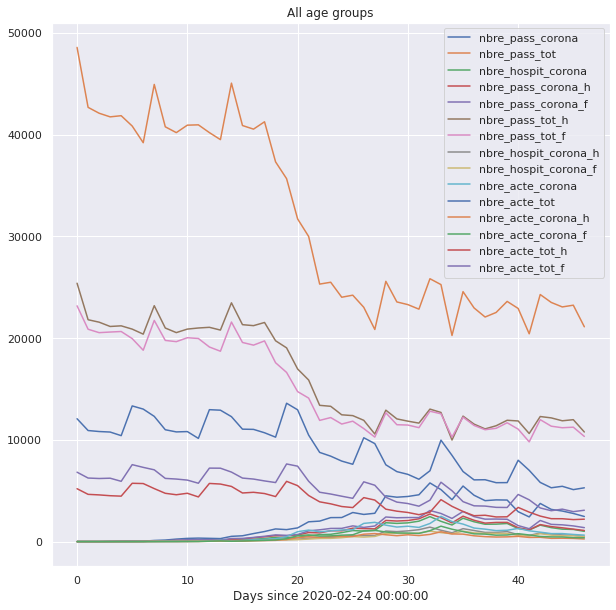

In [257]:
dfGr = PAN.DataFrame(gr_all_age_regions.copy(), columns=gr_all_age_regions.columns[1:])
dt = PAN.to_datetime(dfGr.index,format='%Y-%m-%d' )
elapsedDays = dt - dt[0]
dfGr.index = elapsedDays.days
PLT.figure(figsize=(10,10))
PLT.plot(dfGr);

 # plots an axis lable
PLT.xlabel(f"Days since {dt[0]}")    
PLT.title("All age groups");
# sets our legend for our graph.
PLT.legend(dfGr.columns,loc='best') ;
PAN.set_option('display.max_colwidth', None)
display(meta_QuotReg[[ "Colonne","Description_FR" ]])

### Hospital data
DF: hospNouveau  File: donnees-hospitalieres-nouveaux-covid19

,Colonne,Description_EN
0,dep,Department
1,jour,Date of notice
2,nb,Total amount of hospital services reporting at least one case


,Colonne,Description_EN
0,dep,Department
1,jour,Date of notice
2,incid_hosp,Daily number of newly hospitalized persons
3,incid_rea,Daily number of new intensive care admissions
4,incid_dc,Daily number of newly deceased persons
5,incid_rad,Daily number of new home returns


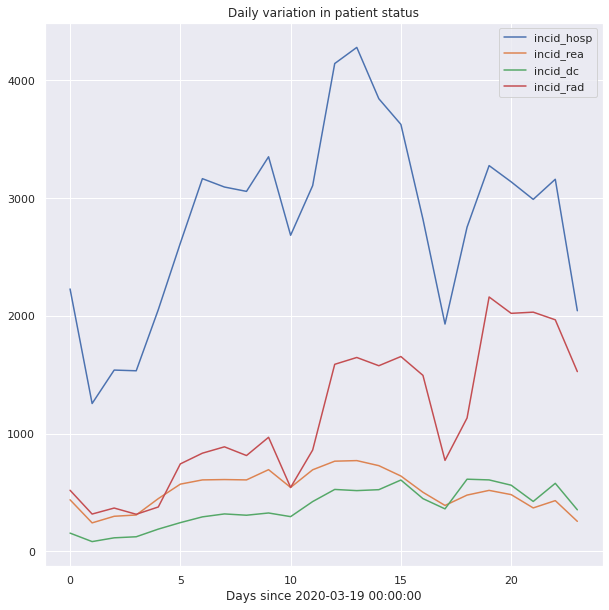

In [298]:
gr_all_data_hospNouveau=data_hospNouveau.groupby('jour').sum()
dfGrHN = PAN.DataFrame(gr_all_data_hospNouveau)
dt = PAN.to_datetime(dfGrHN.index,format='%Y-%m-%d' )
elapsedDays = dt - dt[0]
dfGrHN.index = elapsedDays.days

PLT.figure(figsize=(10,10))
PLT.plot(dfGrHN);
 # plots an axis lable
PLT.xlabel(f"Days since {dt[0]}")    
PLT.title("Daily variation in patient status");
# sets our legend for our graph.
PLT.legend(dfGrHN.columns,loc='best') ;
PAN.set_option('display.max_colwidth', None)
display(meta_HospServices[[ "Colonne","Description_EN" ]])
display(meta_HospIncid[[ "Colonne","Description_EN" ]])

,Colonne,Description_EN
0,dep,Department
1,sexe,Sex
2,jour,Date of notice
3,hosp,Number of people currently hospitalized
4,rea,Number of people currently in resuscitation or critical care
5,rad,Total amount of patient that returned home
6,dc,Total amout of deaths at the hospital


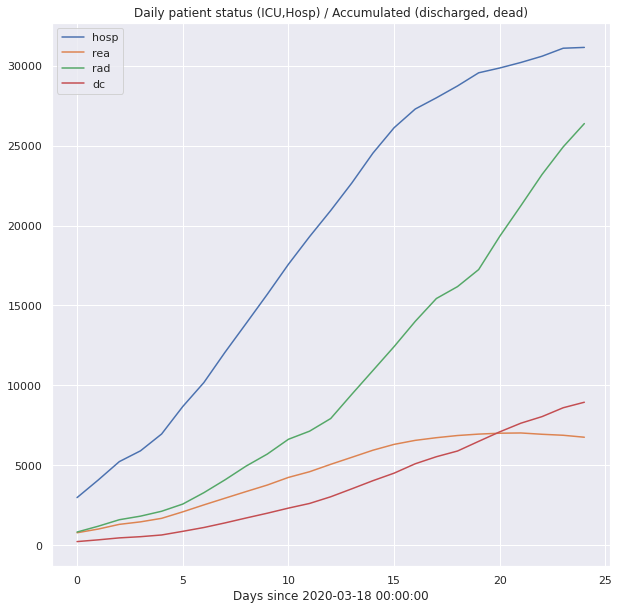

In [299]:
gr_all_data_hosp=data_hosp.loc[data_hosp["sexe"] == 0 ].groupby('jour').sum()
cols = [ c for c in gr_all_data_hosp.columns if c != 'sexe']
dfGrH = PAN.DataFrame(gr_all_data_hosp[cols])
dt = PAN.to_datetime(dfGrH.index,format='%Y-%m-%d' )
elapsedDays = dt - dt[0]
dfGrH.index = elapsedDays.days

PLT.figure(figsize=(10,10))
PLT.plot(dfGrH);
 # plots an axis lable
PLT.xlabel(f"Days since {dt[0]}")    
PLT.title("Daily patient status (ICU,Hosp) / Accumulated (discharged, dead)");
# sets our legend for our graph.
PLT.legend(dfGrH.columns,loc='best') ;
PAN.set_option('display.max_colwidth', None)
display(meta_Hosp[[ "Colonne","Description_EN" ]])